In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.linalg import eigh
import qutip as qt
import sympy as sym
from joblib import Parallel, delayed, cpu_count

%matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

In [2]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0 = h/(2*e0)

In [3]:
C, CJ, Csh, Lq, Lr, Δ, EJ = (
    sq_ext.get_experimental_parameters('qubit_1', return_effective=False))
CR, CF, LF, LR, EJ, Δ, ω_r = (
    sq_ext.get_experimental_parameters('qubit_1', return_effective=True))
C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=False))
CR_prime, CF_prime, LF_prime, LR_prime, EJ_prime, Δ_prime, ω_r_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=True))

LC = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)[2]
LC_prime = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq_prime , Lr_prime , Δ_prime )[2]

only_inner = True
compensate_extra_cap = True
only_renormalization = False

In [4]:
nmax_r = 8
nmax_f = 15

n_eig = 6
φ_ext = 0.5
φ_ext_prime = 0.5

## Full circuit effective Hamiltonian

In [5]:
n_eig  = 5
n_plot = 20
CC_values = np.geomspace(1e-4,2e2, n_plot)

N_elements = 4
basis_states = [(0,0,0,0), (1,0,0,0), (0,0,1,0), (1,0,1,0)]
max_excitations_mediating_states=4
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low  = [f'({i},{j},{k},{l})' for i, j, k, l in basis_states]
labels_high = [f'({i},{j},{k},{l})' for i, j, k, l in mediating_states]

n_eig_extra_low = 2

In [6]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
H_eff_p2_decomp_list = []
ω_f_0      = np.zeros(len(CC_values))
ω_r_0      = np.zeros(len(CC_values))
g_r_limit  = np.zeros(len(CC_values))
g_fq_limit = np.zeros(len(CC_values))
g_xx_pert  = np.zeros(len(CC_values), dtype='complex')
g_zz_pert  = np.zeros(len(CC_values), dtype='complex')
g_yy_pert  = np.zeros(len(CC_values), dtype='complex')
X          = np.zeros(len(CC_values), dtype='complex')
E_low_vs_Δ = np.zeros([len(CC_values), 4])
C_inv_coupling = np.zeros([len(CC_values)])

for i, CC in enumerate(CC_values):
    C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization)
    C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)
    C_inv_coupling[i] = np.abs(C_inv_qubit_C_qubit[0,2])
    CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
    CR_tilde = C_inv_qubit_C_qubit[1, 1] ** -1
    CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
    CR_prime_tilde = C_inv_qubit_C_qubit[3, 3] ** -1
    
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF_tilde, L_F_eff=LF, Δ=Δ, EJ=EJ, nmax_f=nmax_f, φ_ext=φ_ext)
    resonator = sq_ext.sq_resonator(C_R_eff=CR_tilde, L_R_eff=LR, Δ=Δ, EJ=EJ, nmax_r=nmax_r)
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext_prime)
    resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)
    
    circuits = [fluxonium, resonator, fluxonium_prime, resonator_prime]
    LCs = [LC, LC_prime]
    
    H = sq_ext.hamiltonian_qubit_C_qubit(C_inv_qubit_C_qubit, circuits, LCs, nmax_r=nmax_r, nmax_f=nmax_f)
    H_0_list = [circuit.hamiltonian() for circuit in circuits]
    
    P1, P2, SWT, H_eff_p2_decomp = sq_ext.H_eff_4x4(H_0_list, H, basis_states, mediating_states, n_eig, return_decomposition=True)
    Pauli_p1.append(P1)
    Pauli_p2.append(P2)
    Pauli_SWT.append(SWT)
    H_eff_p2_decomp_list.append(H_eff_p2_decomp)

Pauli_p1 = np.array(Pauli_p1)
Pauli_p2 = np.array(Pauli_p2)
Pauli_SWT = np.array(Pauli_SWT)

In [7]:
Pauli_p1_full  = Pauli_p1 
Pauli_p2_full  = Pauli_p2 
Pauli_SWT_full = Pauli_SWT

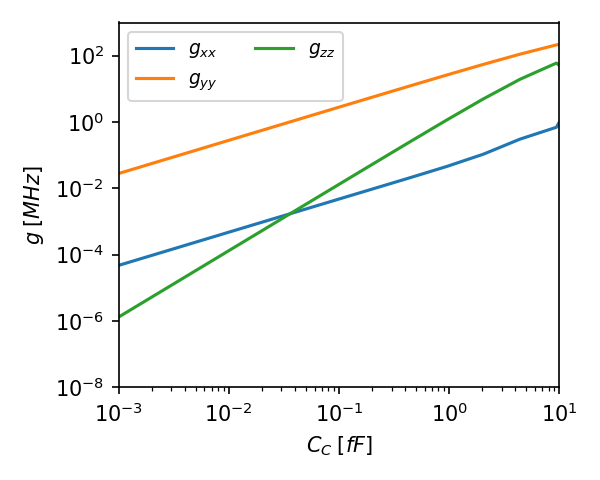

In [8]:
fig, ax1 = plt.subplots(figsize =np.array([5,4])*0.8, dpi=150)
linestyles = ['-', '--','-' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True


for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==0 or i==2:
    if i==0 or i==1:
    # if i ==2:
        continue

    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])
    ωf = np.abs(Pauli[:, 0,-1])
    ωr = np.abs(Pauli[:, -1,0])

    ax1.plot(CC_values, σxσx * 1e3, color = colors[0], linestyle=linestyles[i], label = r'$g_{xx}$')
    ax1.plot(CC_values, σyσy * 1e3, color = colors[1], linestyle=linestyles[i], label = r'$g_{yy}$')
    ax1.plot(CC_values, σzσz * 1e3, color = colors[2], linestyle=linestyles[i], label = r'$g_{zz}$')
    

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-8,1e3])
ax1.set_xlim([1e-3,1e1])
ax1.set_ylabel('$g \; [MHz]$')
ax1.set_xlabel('$C_C\; [fF]$')

# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
# figs.export('g_qubit_C_qubit_vs_Cc.pdf', fig)
fig.show()

C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


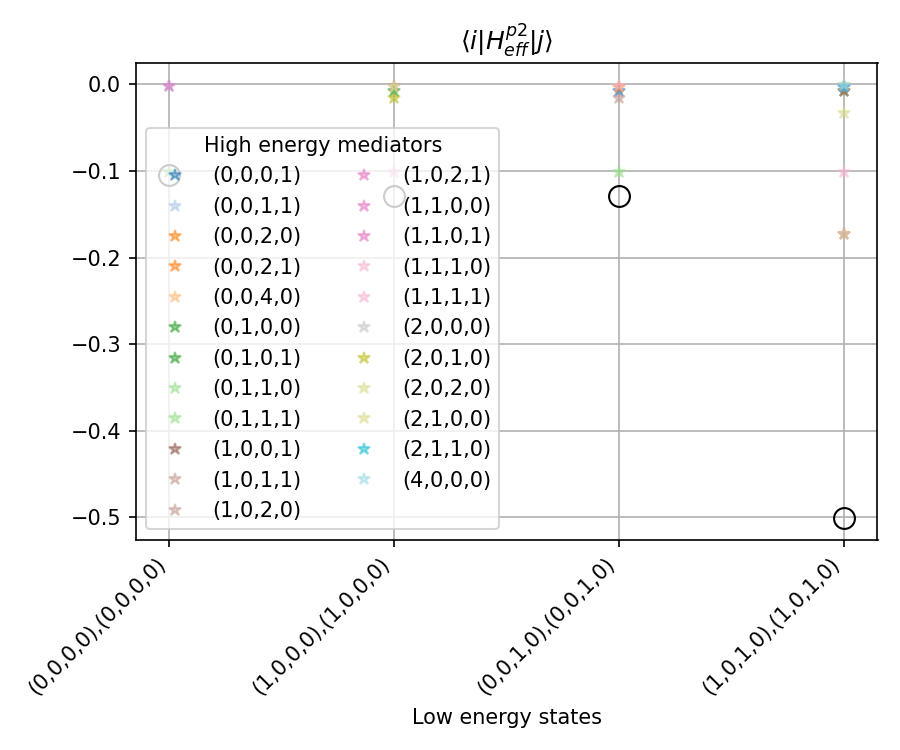

In [9]:
sq_ext.plot_second_order_contributions(H_eff_p2_decomp_list[15], labels_low, labels_high, figsize=np.array([6, 5]) * 1,threshold=1e-4)

## Qubit-Qubit effective Hamiltonian

In [6]:
n_eig  = 5
# n_plot = 20
# CC_values = np.geomspace(1e-4,2e2)

N_elements = 2
basis_states = [(0,0), (1,0), (0,1), (1,1)]
max_excitations_mediating_states=4
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low = [f'({i},{j})' for i, j in basis_states]
labels_high = [f'({i},{j})' for i, j in mediating_states]

n_eig_extra_low = 2

In [7]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
ω_f_0      = np.zeros(len(CC_values))
ω_r_0      = np.zeros(len(CC_values))
g_r_limit  = np.zeros(len(CC_values))
g_fq_limit = np.zeros(len(CC_values))
g_xx_pert  = np.zeros(len(CC_values), dtype='complex')
g_zz_pert  = np.zeros(len(CC_values), dtype='complex')
g_yy_pert  = np.zeros(len(CC_values), dtype='complex')
X          = np.zeros(len(CC_values), dtype='complex')
E_low_vs_Δ = np.zeros([len(CC_values), 4])
C_inv_coupling = np.zeros([len(CC_values)])

for i, CC in enumerate(CC_values):
    C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization)
    C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)
    C_inv_coupling[i] = np.abs(C_inv_qubit_C_qubit[0,2])
    CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
    CR_tilde = C_inv_qubit_C_qubit[1, 1] ** -1
    CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
    CR_prime_tilde = C_inv_qubit_C_qubit[3, 3] ** -1
    
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF_tilde, L_F_eff=LF, Δ=Δ, EJ=EJ, nmax_f=nmax_f, φ_ext=φ_ext)
    resonator = sq_ext.sq_resonator(C_R_eff=CR_tilde, L_R_eff=LR, Δ=Δ, EJ=EJ, nmax_r=nmax_r)
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext_prime)
    resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)
    
    # circuits = [fluxonium, resonator, fluxonium_prime, resonator_prime]
    LCs = [LC, LC_prime]

    H_0, H = sq_ext.hamiltonian_fluxonium_C_fluxonium(C_inv_qubit_C_qubit[[0,2],:][:,[0,2]], [fluxonium,fluxonium_prime], nmax_f=nmax_f,return_H_0=True )

    H1 = fluxonium.hamiltonian()
    H2 = fluxonium_prime.hamiltonian()
    H_0_list = [H1, H2]
    
    P1, P2, SWT = sq_ext.H_eff_4x4(H_0_list, H, basis_states, mediating_states, n_eig)
    Pauli_p1.append(P1)
    Pauli_p2.append(P2)
    Pauli_SWT.append(SWT)

    fluxonium.diag(3);
    fluxonium_prime.diag(3);
    omega_1 = fluxonium.efreqs[1]-fluxonium.efreqs[0]
    omega_2 = fluxonium_prime.efreqs[1]-fluxonium_prime.efreqs[0]
    alpha_1 = fluxonium.efreqs[2]-fluxonium.efreqs[1]
    alpha_2 = fluxonium_prime.efreqs[2]-fluxonium_prime.efreqs[1]
       
    Q_f1 = fluxonium.charge_op(0, basis='eig')
    Q_f2 = fluxonium_prime.charge_op(0, basis='eig')
    
    g_yy_pert[i] = C_inv_qubit_C_qubit[0,2] * fF **-1  *  Q_f1[0,1]*Q_f2[0,1] / (2*np.pi*GHz)
    g_zz_pert[i] =   -( (C_inv_qubit_C_qubit[0,2] * fF **-1)**2 * ( 
                Q_f1[1,2]**2 * Q_f2[0,1]**2/(+alpha_1+omega_2) +
                Q_f1[0,1]**2 * Q_f2[1,2]**2/(+omega_1+alpha_2) +
                Q_f1[1,2]**2 * Q_f2[1,2]**2/(-alpha_1-alpha_2) +
                Q_f1[1,2]**2 * Q_f2[0,1]**2/(-alpha_1+omega_2) +
                Q_f1[0,1]**2 * Q_f2[1,2]**2/(+omega_1-alpha_2)  
                 )/ (2*np.pi*GHz)**2) / 4
    
Pauli_p1 = np.array(Pauli_p1)
Pauli_p2 = np.array(Pauli_p2)
Pauli_SWT = np.array(Pauli_SWT)

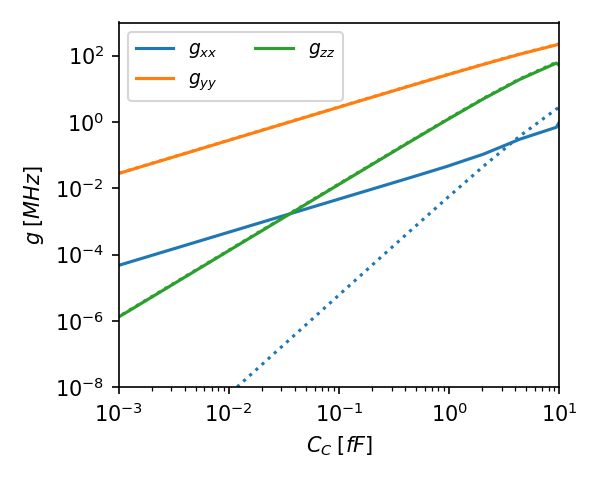

In [12]:
fig, ax1 = plt.subplots(figsize =np.array([5,4])*0.8, dpi=150)
linestyles = ['-', '--','-' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True


for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==0 or i==2:
    if i==0 or i==1:
    # if i ==2:
        continue

    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])
    σxσx_full = np.abs(Pauli_SWT_full[:, 1,1])
    σyσy_full = np.abs(Pauli_SWT_full[:, 2,2])
    σzσz_full = np.abs(Pauli_SWT_full[:, 3,3])
    ωf = np.abs(Pauli[:, 0,-1])
    ωr = np.abs(Pauli[:, -1,0])
    
    ax1.plot(CC_values, σxσx_full * 1e3, color = colors[0], linestyle='-', label = r'$g_{xx}$')
    ax1.plot(CC_values, σyσy_full * 1e3, color = colors[1], linestyle='-', label = r'$g_{yy}$')
    ax1.plot(CC_values, σzσz_full * 1e3, color = colors[2], linestyle='-', label = r'$g_{zz}$')

    ax1.plot(CC_values, σxσx * 1e3, color = colors[0], linestyle=':' )
    ax1.plot(CC_values, σyσy * 1e3, color = colors[1], linestyle=':' )
    ax1.plot(CC_values, σzσz * 1e3, color = colors[2], linestyle=':' )
    # ax1.plot(CC_values[::4], g_yy_pert[::4] * 1e3, 'o', color = colors[1],   markersize='4')
    # ax1.plot(CC_values[::4], g_zz_pert[::4] * 1e3,'o', color = colors[2],markersize='4')
    

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-8,1e3])
ax1.set_xlim([1e-3,1e1])
ax1.set_ylabel('$g \; [MHz]$')
ax1.set_xlabel('$C_C\; [fF]$')

# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
# figs.export('g_QR_C_QR_vs_Cc.pdf', fig)
fig.show()

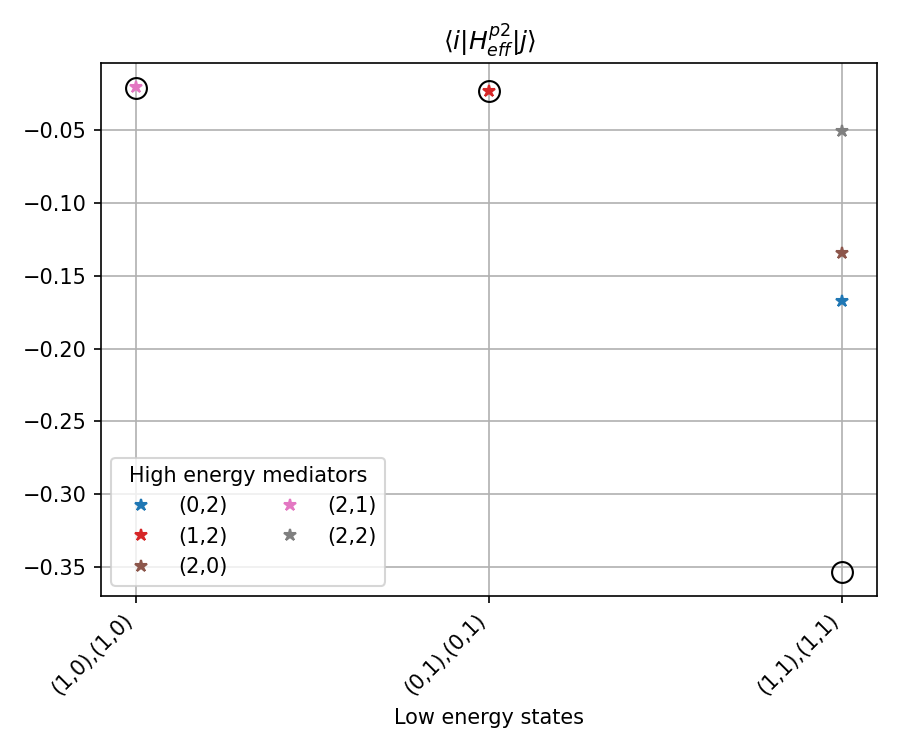

In [140]:
sq_ext.plot_second_order_contributions(H_eff_p2_decomposed, labels_low, labels_high, figsize=np.array([6, 5]) * 1,threshold=1e-3)

## Vs phi ext

In [5]:
only_inner = True
compensate_extra_cap = True
only_renormalization = False
CC = 1


C, CJ, Csh, Lq, Lr, Δ, EJ = (
    sq_ext.get_experimental_parameters('qubit_1', return_effective=False))
CR, CF, LF, LR, EJ, Δ, ω_r = (
    sq_ext.get_experimental_parameters('qubit_1', return_effective=True))
C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=False))
CR_prime, CF_prime, LF_prime, LR_prime, EJ_prime, Δ_prime, ω_r_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=True))

LC = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)[2]
LC_prime = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq_prime , Lr_prime , Δ_prime )[2]



In [37]:

n_plot = 100
φ_ext_values = np.linspace(0.5, 0.55, n_plot)
nmax_r = 10
nmax_f = 15

N_elements_uc = 4
basis_states_uc = [(0,0,0,0), (0,0,1,0), (1,0,0,0), (1,0,1,0)]
max_excitations_mediating_states_uc=2
mediating_states_uc = sq_ext.generate_mediating_states(N_elements_uc, basis_states_uc, max_excitations_mediating_states_uc)
labels_low_uc  = [f'({i},{j},{k},{l})' for i, j, k, l in basis_states_uc]
labels_high_uc = [f'({i},{j},{k},{l})' for i, j, k, l in mediating_states_uc]
n_eig_uc = 6

N_elements_f = 2
basis_states_f = [(0,0), (0,1), (1,0), (1,1)]
max_excitations_mediating_states_f = 3
mediating_states_f = sq_ext.generate_mediating_states(N_elements_f, basis_states_f, max_excitations_mediating_states_f)
labels_low_f = [f'({i},{j})' for i, j in basis_states_f]
labels_high_f = [f'({i},{j})' for i, j in mediating_states_f]
n_eig_f = 6


In [38]:
C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization)
C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)
CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
CR_tilde = C_inv_qubit_C_qubit[1, 1] ** -1
CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
CR_prime_tilde = C_inv_qubit_C_qubit[3, 3] ** -1

fluxonium_0 = sq_ext.sq_fluxonium(C_F_eff=CF_tilde, L_F_eff=LF, Δ=Δ, EJ=EJ, nmax_f=nmax_f, φ_ext=0.5)
resonator = sq_ext.sq_resonator(C_R_eff=CR_tilde, L_R_eff=LR, Δ=Δ, EJ=EJ, nmax_r=nmax_r)
fluxonium_prime_0 = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=0.5)
resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)

LCs = [LC, LC_prime]

circuits_0_uc = [fluxonium_0, resonator, fluxonium_prime_0, resonator_prime]
H_0_list_uc = [circuit.hamiltonian() for circuit in circuits_0_uc]
H_0_uc, E_0_uc, ψ_0_basis_uc, ψ_0_mediating_uc = sq_ext.ψ_0_from_H_0(H_0_list_uc, basis_states_uc, mediating_states_uc, n_eig_uc)

circuits_0_f = [fluxonium_0, fluxonium_prime_0]
H_0_list_f = [circuit.hamiltonian() for circuit in circuits_0_f]
H_0_f, E_0_f, ψ_0_basis_f, ψ_0_mediating_f = sq_ext.ψ_0_from_H_0(H_0_list_f, basis_states_f, mediating_states_f, n_eig_f)


In [39]:
Pauli_p1_uc  = np.zeros([len(φ_ext_values),4,4])
Pauli_p2_uc  = np.zeros([len(φ_ext_values),4,4])
Pauli_SWT_uc = np.zeros([len(φ_ext_values),4,4])
E_uc         = np.zeros([len(φ_ext_values),4])
E_uc_disp    = np.zeros([len(φ_ext_values),4])

Pauli_p1_f  = np.zeros([len(φ_ext_values),4,4])
Pauli_p2_f  = np.zeros([len(φ_ext_values),4,4])
Pauli_SWT_f = np.zeros([len(φ_ext_values),4,4])
E_f         = np.zeros([len(φ_ext_values),4])
E_f_disp    = np.zeros([len(φ_ext_values),4])

E_full    = np.zeros([len(φ_ext_values),16])


[circuit.diag(3) for circuit in circuits_0_uc]
gΦ0 = sq_ext.get_parameters_QR(fluxonium_0, resonator, LC)
gΦ1 = sq_ext.get_parameters_QR(fluxonium_prime_0, resonator_prime, LC_prime)
g_qq, g_rr, g_qr, g_rq = (sq_ext.get_parameters_QR_C_QR
                      (fluxonium_0, resonator, fluxonium_prime_0, resonator_prime, C_inv_qubit_C_qubit))
ω_q0, ω_r0, ω_q1, ω_r1 = [sq_ext.diag(H_0, n_eig=2, remove_ground=True)[0][1] for H_0 in H_0_list_uc]
fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF_tilde, L_F_eff=LF, Δ=Δ, EJ=EJ, nmax_f=nmax_f, φ_ext=0.5)
H_f0 = fluxonium.hamiltonian()
ω_f0 = sq_ext.diag(H_f0, 2,solver='numpy', remove_ground=True)[0][1]

for i, φ_ext in enumerate(φ_ext_values):
    print(i)
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF_tilde, L_F_eff=LF, Δ=Δ, EJ=EJ, nmax_f=nmax_f, φ_ext=0.5)
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext)
    
    H_f1 = fluxonium_prime.hamiltonian()
    ω_f1 = sq_ext.diag(H_f1,2,solver='numpy', remove_ground=True)[0][1]
    
    circuits_uc = [fluxonium, resonator, fluxonium_prime, resonator_prime]
    H_uc = sq_ext.hamiltonian_qubit_C_qubit(C_inv_qubit_C_qubit, circuits_uc, LCs, nmax_r=nmax_r, nmax_f=nmax_f)
    Pauli_p1_uc[i,:], Pauli_p2_uc[i,:], Pauli_SWT_uc[i,:], H_eff_p2_decomp_uc, E_uc[i] =\
        sq_ext.H_eff_4x4(H_uc, H_0_uc, E_0_uc, ψ_0_basis_uc, ψ_0_mediating_uc, n_eig_uc, return_decomposition=True, return_E=True)
    
    E_full[i,:] = sq_ext.diag(H_uc,n_eig=16,remove_ground=True)[0]
    
    circuits_f = [fluxonium, fluxonium_prime]
    H_f = sq_ext.hamiltonian_fluxonium_C_fluxonium(C_inv_qubit_C_qubit[[0,2],:][:,[0,2]], circuits_f, nmax_f=nmax_f)
    Pauli_p1_f[i,:], Pauli_p2_f[i,:], Pauli_SWT_f[i,:], H_eff_p2_decomp_f, E_f[i]  =\
        sq_ext.H_eff_4x4(H_f, H_0_f, E_0_f, ψ_0_basis_f, ψ_0_mediating_f, n_eig_f, return_decomposition=True, return_E=True)
    # 
    # if ω_f1 >=ω_f0:
    #     aux = E_uc[i,1]
    #     E_uc[i,1] = E_uc[i,2]
    #     E_uc[i,2] = aux
    #     aux = E_f[i,1]
    #     E_f[i,1] = E_f[i,2]
    #     E_f[i,2] = aux
    #     
    if ω_f1 <=ω_f0:
        E_f_disp[i,1] = E_f[i,1] - (gΦ1**2 / (ω_r1 - ω_f1) + g_rq**2 / (ω_r0 - ω_f1))
        E_f_disp[i,2] = E_f[i,2] - (gΦ0**2 / (ω_r0 - ω_f0) + g_qr**2 / (ω_r1 - ω_f0))
    else:
        E_f_disp[i,1] = E_f[i,1] - (gΦ0**2 / (ω_r0 - ω_f0) + g_qr**2 / (ω_r1 - ω_f0)) 
        E_f_disp[i,2] = E_f[i,2] - (gΦ1**2 / (ω_r1 - ω_f1) + g_rq**2 / (ω_r0 - ω_f1)) 
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [40]:
# ω_r0 = E_full[0,4]
# ω_r1 = E_full[0,3]

ω_q0, ω_r0, ω_q1, ω_r1 = [sq_ext.diag(H_0, n_eig=2, remove_ground=True)[0][1] for H_0 in H_0_list_uc]
# ω_r0*=0.88
# ω_r1*=0.88
# gΦ0 = sq_ext.get_parameters_QR(fluxonium_0, resonator, LC)
# gΦ1 = sq_ext.get_parameters_QR(fluxonium_prime_0, resonator_prime, LC_prime)
# gΦ0 *= 1.25
# gΦ1 *= 1.25
ω_q0, ω_r0, ω_q1, ω_r1

(3.655656551911168, 6.261402355106367, 3.370097350125021, 6.045586119267438)

In [41]:
# ω_q0, ω_q1, ω_r1, ω_r0  = E_full[0,:][1:5]

In [42]:
importlib.reload(sq_ext)

E_0_q0 = fluxonium_0.diag(3)[0]
E_0_q1 = fluxonium_prime_0.diag(3)[0]

# [circuit.diag(3) for circuit in circuits_0_uc]
# gΦ0 = sq_ext.get_parameters_QR(fluxonium_0, resonator, LC)
# gΦ1 = sq_ext.get_parameters_QR(fluxonium_prime_0, resonator_prime, LC_prime)
# g_qq, g_rr, g_qr, g_rq = (sq_ext.get_parameters_QR_C_QR
#                       (fluxonium_0, resonator, fluxonium_prime_0, resonator_prime, C_inv_qubit_C_qubit))

n_eig_uc = 16
E_qo                 = np.zeros([len(φ_ext_values), n_eig_uc])
gΦ0_vs_φ_ext         = np.zeros([len(φ_ext_values)])
gΦ1_vs_φ_ext         = np.zeros([len(φ_ext_values)])

for i, φ_ext in enumerate(φ_ext_values):
    
    
    gx_0, gz_0 = sq_ext.fluxonium_qubit_ops_vs_φ_ext(EJ, E_0_q0, fluxonium_0, φ_ext=0.5, return_full=True)
    gx_1, gz_1 = sq_ext.fluxonium_qubit_ops_vs_φ_ext(EJ_prime, E_0_q1, fluxonium_prime_0, φ_ext, return_full=True)
    
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext)
    fluxonium_prime.diag(2)
    resonator_prime.diag(2)
    # fluxonium.diag(2)
    # resonator.diag(2)
    # gΦ0 = sq_ext.get_parameters_QR(fluxonium, resonator, LC)
    # gΦ1 = sq_ext.get_parameters_QR(fluxonium_prime_0, resonator_prime, LC_prime)
    
    # gΦ0_vs_φ_ext[i] =  gΦ0
    # gΦ1_vs_φ_ext[i] =  gΦ1

    g_φ_ext_q1 = sq_ext.decomposition_in_pauli_2x2(sq_ext.H_eff_SWT(fluxonium_prime_0.hamiltonian(),fluxonium_prime.hamiltonian(),2))
    gx_1, gz_1 = [g_φ_ext_q1[1],g_φ_ext_q1[-1]+ω_q1/2]
    H_qo = sq_ext. hamiltonian_QR_C_QR_low_ene_qtip(ω_q0, gx_0, gz_0, ω_r0, gΦ0,
                                                    ω_q1, gx_1, gz_1, ω_r1, gΦ1,
                                                    g_qq, g_rr, g_qr, g_rq)
    E_qo[i] = sq_ext.diag(H_qo,n_eig=n_eig_uc, out='None', solver='numpy', remove_ground=True)[0]
    # try:
    #     subspace_indices = sq_ext.find_close_indices_unique(E_full[i], E, tolerance=1e-4, print_error=True)
    # except:
    #     pass
    # E_qo[i]  = E[subspace_indices]


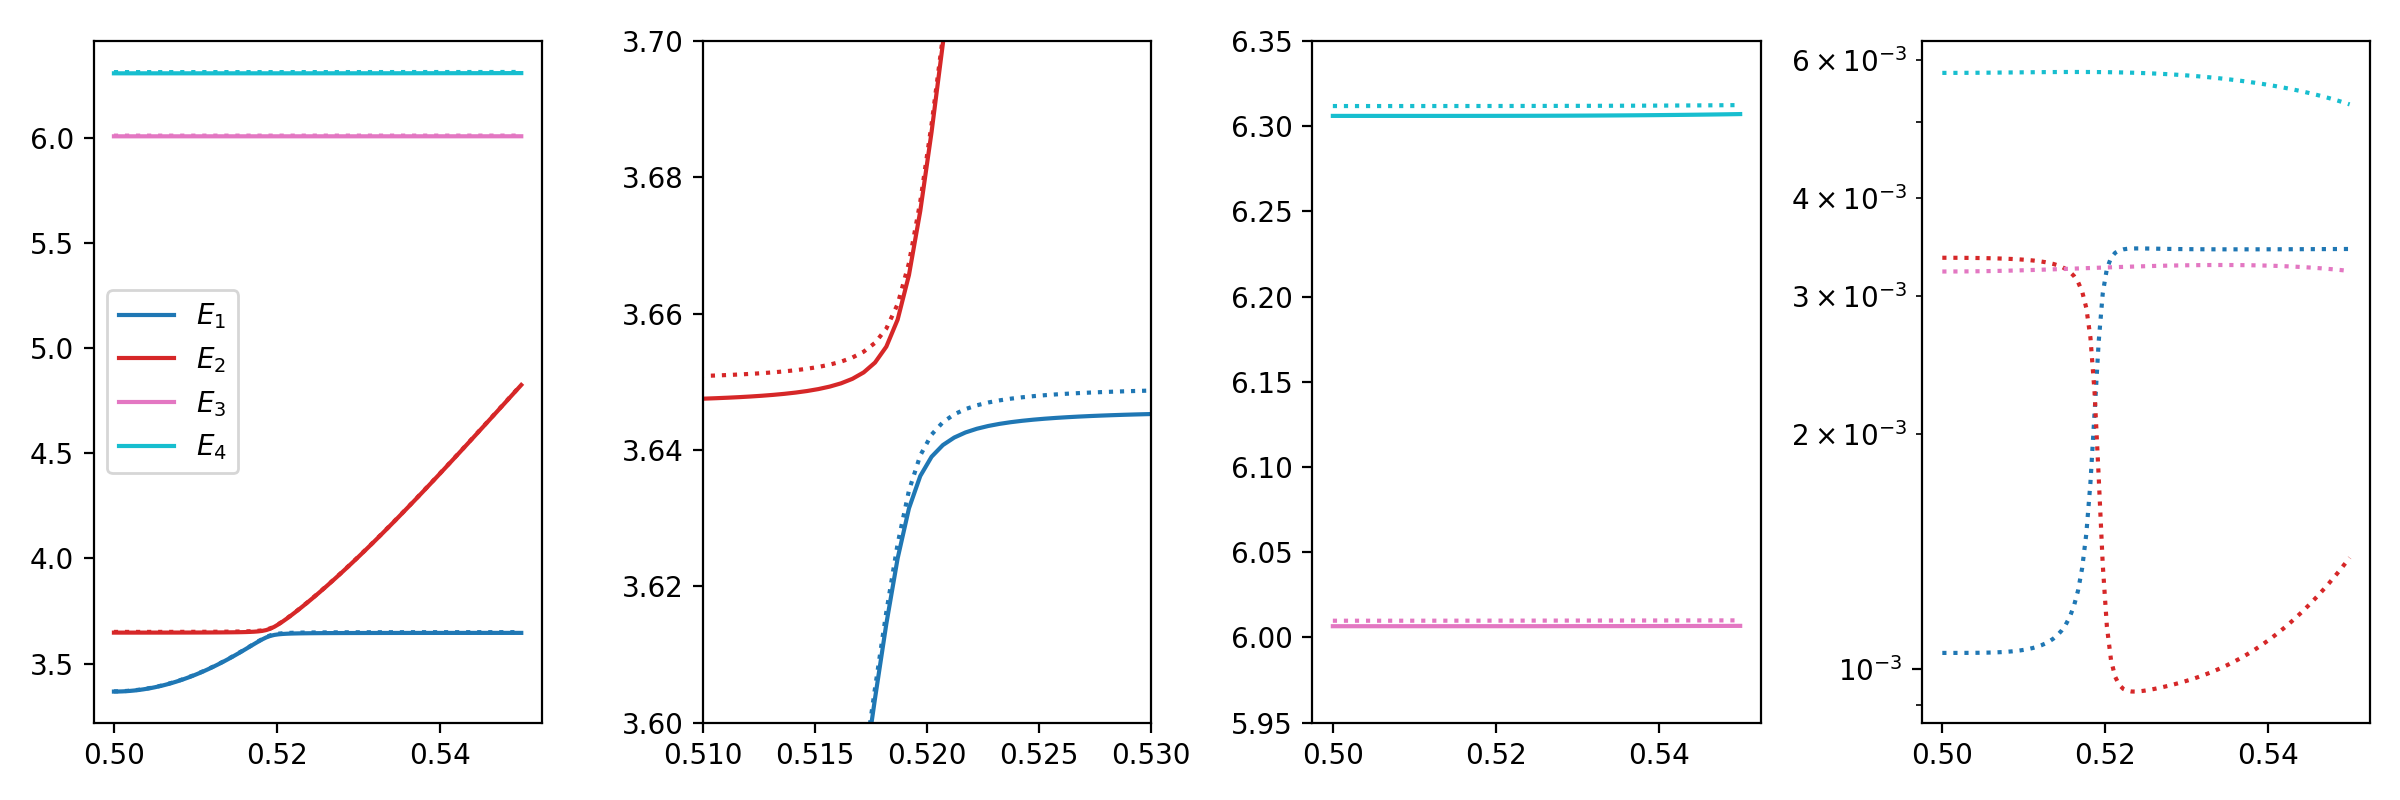

In [47]:
colors = figs.generate_colors_from_colormap(4, 'tab10')

fig, (ax1, ax1_copy, ax1_copy2,  ax2,) = plt.subplots(ncols=4, dpi=200, figsize=[12,4])

# ax1.plot(φ_ext_values, E_full, 'k')

for i in range(1,5):
    [ax.plot(φ_ext_values, E_full[:,i]      , color=colors[i-1], label=f'$E_{i}$' ) for ax in [ax1, ax1_copy, ax1_copy2]]
    [ax.plot(φ_ext_values, E_qo[:,i]        , color=colors[i-1], linestyle=':') for ax in [ax1, ax1_copy, ax1_copy2]]
    # [ax.plot(φ_ext_values, E_uc[:,i]        , color=colors[i-1], label=f'$E_{i}$' ) for ax in [ax1, ax1_copy]]
    # [ax.plot(φ_ext_values, E_f [:,i]        , color=colors[i-1], linestyle='None', marker='^', markersize=3) for ax in [ax1, ax1_copy]]
    # [ax.plot(φ_ext_values, E_f_disp [:,i]   , color=colors[i-1], linestyle='None', marker='s', markersize=3) for ax in [ax1, ax1_copy]]

    ax2.plot(φ_ext_values, np.abs(E_qo[:,i]-E_full[:,i])    , color=colors[i-1], linestyle=':')
    # ax2.plot(φ_ext_values, np.abs(E_f [:,i] -E_uc[:,i])     , color=colors[i-1], linestyle='None', marker='^', markersize=3)
    # ax2.plot(φ_ext_values, np.abs(E_f_disp [:,i] -E_uc[:,i]), color=colors[i-1], linestyle='None', marker='s', markersize=3)


# for i in rang e(1,16):
    # ax1.plot(φ_ext_values, E_qo[:,i]-E_qo[:,0],color=colors[i], label=f'$E_{i}$')
    # ax1.plot(φ_ext_values, E_full[:,i] , 'k' )
# ax1.plot(φ_ext_values, E_qo[:,6]-E_qo[:,0], 'k', linestyle='None', marker='.', markersize=0.5)

ax1_copy.set_ylim([3.6, 3.7])  
ax1_copy.set_xlim([0.51, 0.53])  
ax1_copy2.set_ylim([5.95,6.35])  
ax2.set_yscale('log')
# ax2.set_ylim([1e-4, 1e-1])
ax1.legend()
fig.tight_layout()

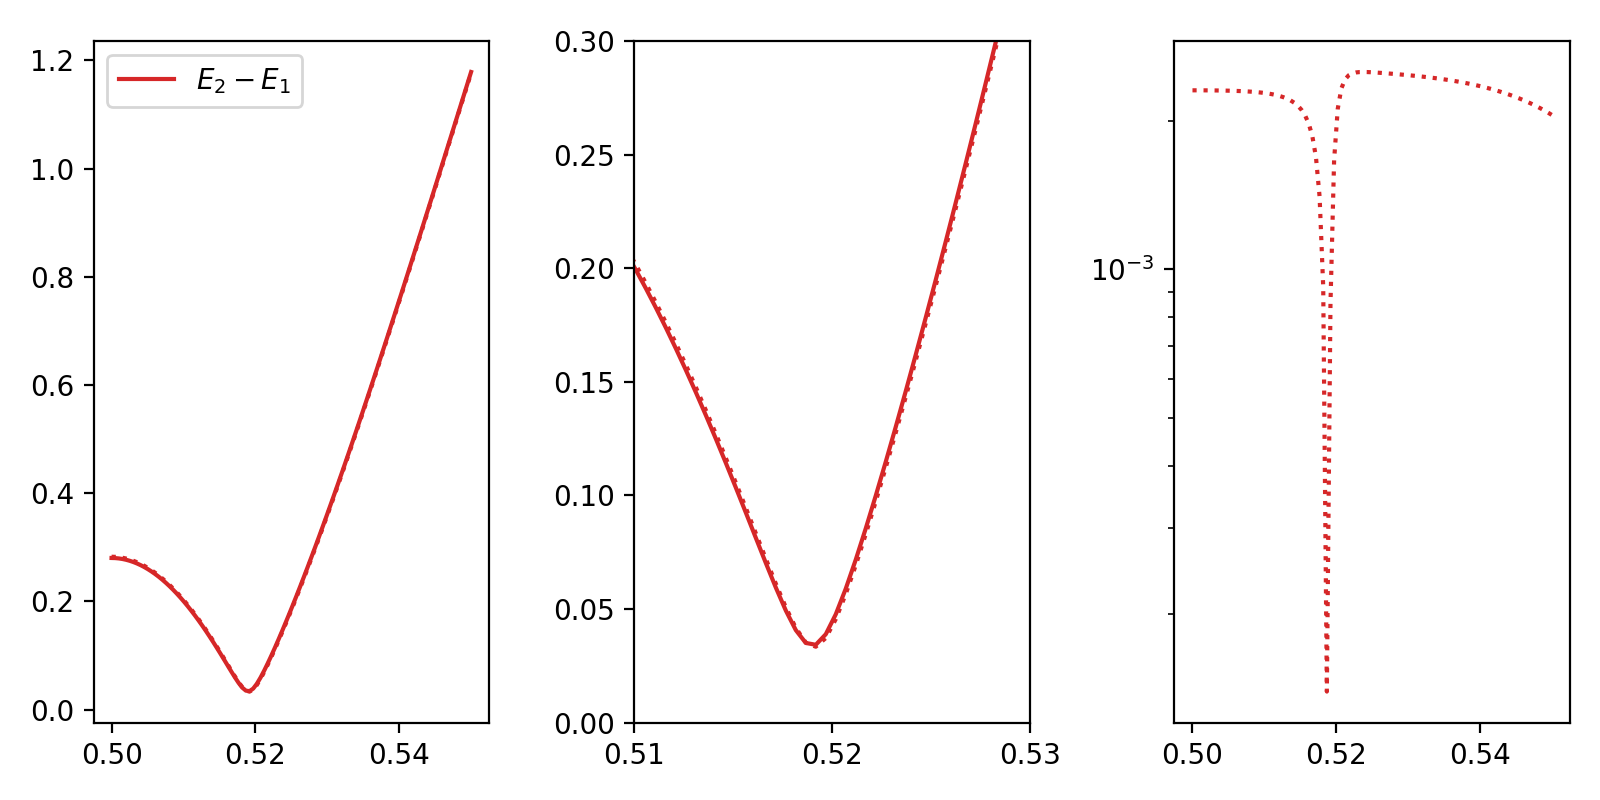

In [48]:
colors = figs.generate_colors_from_colormap(4, 'tab10')

fig, (ax1, ax1_copy, ax2) = plt.subplots(ncols=3, dpi=200, figsize=[8,4])


[ax.plot(φ_ext_values, E_full[:,2]-E_full[:,1] , color=colors[1], label=f'$E_{2}-E_{1}$' ) for ax in [ax1, ax1_copy]]
[ax.plot(φ_ext_values, E_qo[:,2]-E_qo[:,1]     , color=colors[1], linestyle=':') for ax in [ax1, ax1_copy]]

ax2.plot(φ_ext_values, np.abs(E_full[:,2]-E_full[:,1] - (E_qo[:,2]-E_qo[:,1]))    , color=colors[1], linestyle=':')

ax1_copy.set_ylim([0,.3])  
ax1_copy.set_xlim([0.51, 0.53])  
ax2.set_yscale('log')
# ax2.set_ylim([1e-4, 1e-1])
ax1.legend()
fig.tight_layout()

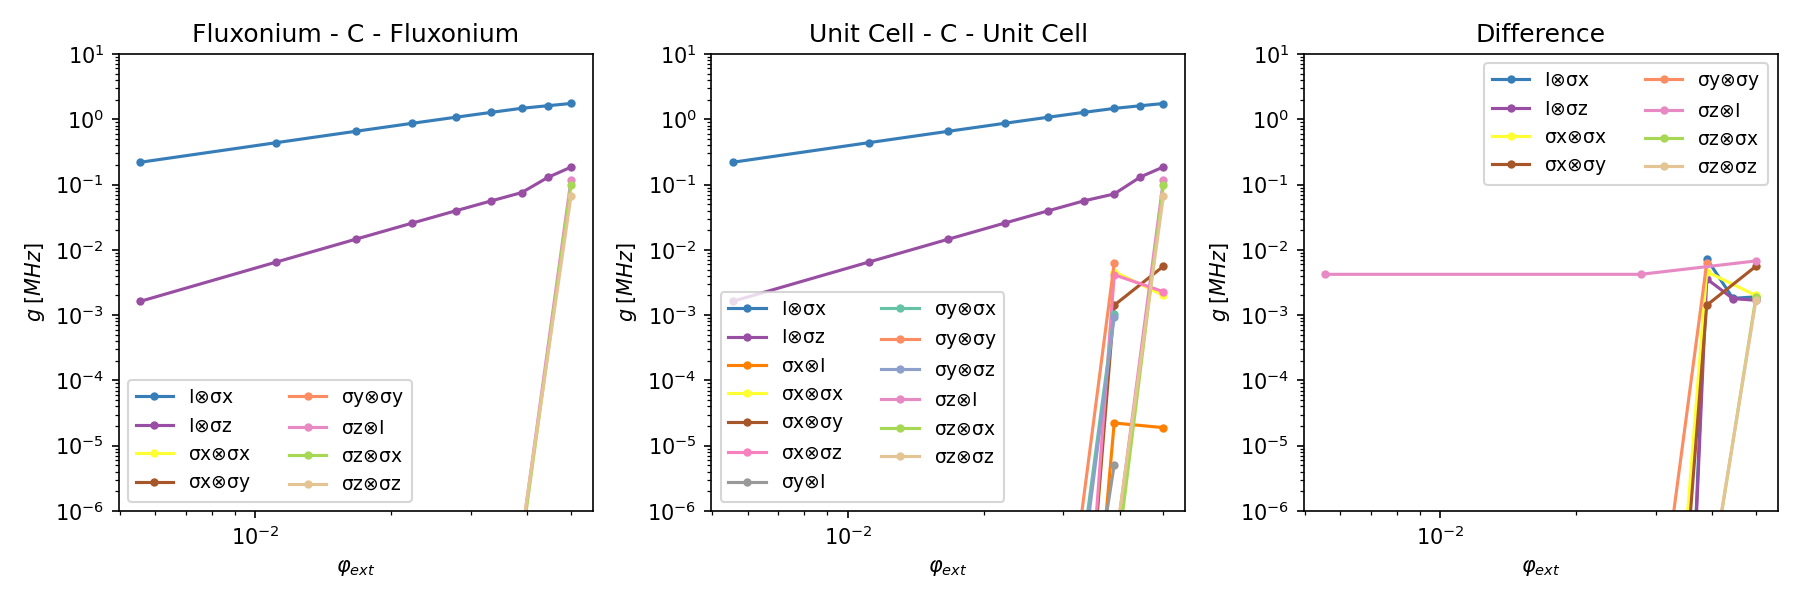

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, dpi=150, figsize=[12,4])
linestyles = ['-', '--','-' ]
labels = ['I', 'σx', 'σy', 'σz']
# colors = figs.generate_colors_from_colormap(16, 'tab20')
colors = figs.generate_colors_from_colormap(9, 'Set1') + figs.generate_colors_from_colormap(9, 'Set2')

Pauli_decomp_uc = Pauli_SWT_uc
Pauli_decomp_f = Pauli_SWT_f

for i in range(4):
    for j in range(4):
        if i==j==0:
            continue
        if np.any( np.abs(Pauli_decomp_f[1:,i,j]- Pauli_decomp_f[0,i,j]) >1e-12):
            ax1.plot(φ_ext_values[1::i+1]-0.5,np.abs(Pauli_decomp_f[1:,i,j]- Pauli_decomp_f[0,i,j])[::i+1],color = colors[i*4+j], label = f'{labels[i]}' + r'$\otimes$' + f'{labels[j]}', marker='.' )
            
            ax3.plot(φ_ext_values[1::i+1]-0.5,np.abs(Pauli_decomp_f[1:,i,j]- Pauli_decomp_uc[1:,i,j])[::i+1],color = colors[i*4+j], label = f'{labels[i]}' + r'$\otimes$' + f'{labels[j]}', marker='.'  )
            
        if np.any( np.abs(Pauli_decomp_uc[1:,i,j]- Pauli_decomp_uc[0,i,j]) >1e-12):
            ax2.plot(φ_ext_values[1::i+1]-0.5,np.abs(Pauli_decomp_uc[1:,i,j]- Pauli_decomp_uc[0,i,j])[::i+1],color = colors[i*4+j], label = f'{labels[i]}' + r'$\otimes$' + f'{labels[j]}' , marker='.' )

for ax in [ax1, ax2, ax3]:
    ax.legend(ncol=2, fontsize=9)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-6,1e1)
    ax.set_ylabel('$g \; [MHz]$')
    ax.set_xlabel(r'$\varphi_{ext}$')

ax1.set_title('Fluxonium - C - Fluxonium')
ax2.set_title('Unit Cell - C - Unit Cell')
ax3.set_title('Difference')

fig.tight_layout()